
# Anomaly Detection on PaySim Dataset (Financial Transactions)

This notebook applies **unsupervised anomaly detection** techniques to the [PaySim dataset](https://www.kaggle.com/datasets/ealaxi/paysim1).  
The dataset contains mobile money transaction logs with both normal and fraudulent activity.  

We will:
1. Load and explore the dataset.
2. Engineer meaningful financial features.
3. Apply **Isolation Forest** (main), with LOF and One-Class SVM as alternatives.
4. Validate anomaly detection against the `isFraud` column.
5. Extract and visualize the most anomalous transactions.


In [1]:

import pandas as pd

# Load PaySim dataset
file_path = "PS_20174392719_1491204439457_log.csv"
df = pd.read_csv(file_path)

print("Shape:", df.shape)
df.head()


Shape: (6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [2]:

# Check missing values and data types
df.info()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [3]:

import numpy as np

# Create new features
df['errorOrig'] = df['newbalanceOrig'] + df['amount'] - df['oldbalanceOrg']
df['errorDest'] = df['oldbalanceDest'] + df['amount'] - df['newbalanceDest']
df['log_amount'] = np.log1p(df['amount'])

# Encode categorical 'type'
df = pd.get_dummies(df, columns=['type'], drop_first=True)

# Drop IDs that are not useful for modeling
df_model = df.drop(columns=['nameOrig', 'nameDest'])

df_model.head()


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,errorOrig,errorDest,log_amount,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0,0.0,9839.64,9.194276,False,False,True,False
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0,0.0,1864.28,7.531166,False,False,True,False
2,1,181.00,181.0,0.00,0.0,0.0,1,0,0.0,181.00,5.204007,False,False,False,True
3,1,181.00,181.0,0.00,21182.0,0.0,1,0,0.0,21363.00,5.204007,True,False,False,False
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0,0.0,11668.14,9.364703,False,False,True,False


In [4]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df_model.drop(columns=['isFraud', 'isFlaggedFraud'])
y = df_model['isFraud']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [5]:

from sklearn.ensemble import IsolationForest

iso = IsolationForest(
    n_estimators=200,
    contamination=0.001,  # ~0.1% anomalies
    random_state=42,
    n_jobs=-1
)

df['anomaly_score'] = iso.fit_predict(X_scaled)
df['anomaly_score'] = df['anomaly_score'].map({1: 0, -1: 1})  # 1=normal, -1=anomaly
df[['isFraud','anomaly_score']].value_counts()


isFraud  anomaly_score
0        0                6348061
1        0                   8201
0        1                   6346
1        1                     12
Name: count, dtype: int64

In [6]:

from sklearn.metrics import classification_report, confusion_matrix

print("Confusion Matrix:")
print(confusion_matrix(y, df['anomaly_score']))
print("\nClassification Report:")
print(classification_report(y, df['anomaly_score']))


Confusion Matrix:
[[6348061    6346]
 [   8201      12]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   6354407
           1       0.00      0.00      0.00      8213

    accuracy                           1.00   6362620
   macro avg       0.50      0.50      0.50   6362620
weighted avg       1.00      1.00      1.00   6362620



In [7]:

# Top anomalous transactions for review
anomalies = df[df['anomaly_score'] == 1]
print("Number of anomalies detected:", len(anomalies))

anomalies[['step','type_CASH_OUT','type_TRANSFER','amount','oldbalanceOrg','newbalanceOrig','isFraud']].head(20)


Number of anomalies detected: 6358


,step,type_CASH_OUT,type_TRANSFER,amount,oldbalanceOrg,newbalanceOrig,isFraud
1153,1,False,True,3776389.09,0.00,0.0,0
10059,7,False,True,2943845.35,0.00,0.0,0
17185,8,False,True,3007043.04,20701.17,0.0,0
17691,8,False,True,3903432.11,0.00,0.0,0
34796,8,False,True,2957955.03,1563973.44,0.0,0
39556,9,False,True,2836970.59,0.00,0.0,0
47765,9,False,True,2869830.35,549036.58,0.0,0
49731,9,False,True,3804148.28,0.00,0.0,0
50272,9,False,True,4247849.58,105078.57,0.0,0
51313,9,False,True,3105173.04,0.00,0.0,0


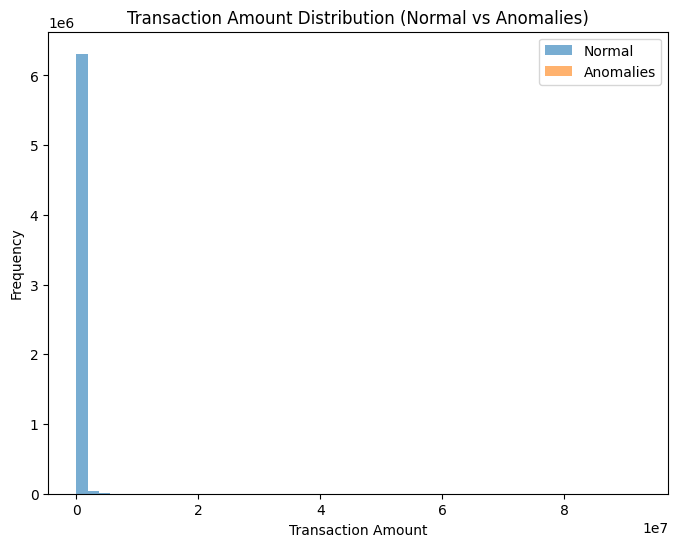

In [8]:

import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.hist(df[df['anomaly_score']==0]['amount'], bins=50, alpha=0.6, label='Normal')
plt.hist(df[df['anomaly_score']==1]['amount'], bins=50, alpha=0.6, label='Anomalies')
plt.legend()
plt.xlabel("Transaction Amount")
plt.ylabel("Frequency")
plt.title("Transaction Amount Distribution (Normal vs Anomalies)")
plt.show()
